# Quickstart example for cancer simulation 

## Import modules 

In [1]:
### Uncomment and execute if the next cell fails with "module not found".` Then reload the kernel.
%cd ../../../..
%pip install -e .
%cd -

/opt/data/repos/cancer_software
Obtaining file:///opt/data/repos/cancer_software
  Found existing installation: CaSim 1.0.0
    Uninstalling CaSim-1.0.0:
      Successfully uninstalled CaSim-1.0.0
  Running setup.py develop for CaSim
Note: you may need to restart the kernel to use updated packages.
/opt/data/repos/cancer_software/docs/source/include/notebooks


In [2]:
# The cancer simulation module.
from casim import casim

In [3]:
#  3rd party modules.
import os, shutil
from wand.image import Image as WImage

## Setup parameters 

In [3]:
parameters=casim.CancerSimulatorParameters(
                                matrix_size=20,
                                number_of_generations=10,
                                division_probability=0.5,
                                advantageous_division_probability=0.8,
                                death_probability=0.1,
                                advantageous_death_probability=0.4,
                                mutation_probability=0.2,
                                advantageous_mutation_probability=0.8,
                                mutations_per_division=10,
                                time_of_advantageous_mutation=30000,
                                number_of_clonal=2,
                                plot_tumour_growth=True,
                                export_tumour=True
                               )

## Setup the simulation engine. 

In [4]:
if os.path.isdir('out'):
    shutil.rmtree('out')

In [5]:
cancer_sim = casim.CancerSimulator(parameters, seed=1, outdir='out/')

## Run the simulation 

In [6]:
cancer_sim.run()

0

<Figure size 432x288 with 0 Axes>

## Display the growth curve. 

In [7]:
image_path=os.path.join(cancer_sim.outdir,'cancer_1', 'simOutput', 'growthCurve.pdf')

In [8]:
img = WImage(filename=image_path)

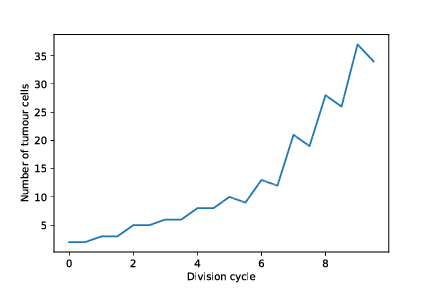

In [9]:
display(img)